In [1]:
library(lme4)
library(afex)
library(emmeans)
library(dplyr)
library(ggplot2)
library(svglite)
library(lmtest)
library(stringr)
library(reshape)
library(tidyr)

Loading required package: Matrix



************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'S', 'KR', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- Get and set global package options with: afex_options()
- Set sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************


Attaching package: ‘afex’


The following object is masked from ‘package:lme4’:

    lmer



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:



In [2]:
chr2 <- c(7,8,9,10,11,12,13,14,15,16,23,24,25,26,27,28,29,30,31)
males <- c(17,18,19,20,21,22,23,24,25,26,27,28,29,30,31)
group1 <- c(1,4,7,10,13,16,19,22,25,29)
group2 <- c(2,5,8,11,14,17,20,23,26,30)
group3 <- c(3,6,9,12,15,18,21,24,27,31)

pfc1<-c(1,5,9,10,14,16,20,24,25,29,33,34)
pfc2<-c(2,6,7,11,15,17,21,22,26,30,31,35)
pfc3<-c(3,4,8,12,13,18,19,23,27,28,32,36)

both1<-c(3,4,8,12,13,18,19,23,27,28,32,36)
both2<-c(1,5,9,10,14,16,20,24,25,29,33,34)
both3<-c(2,6,7,11,15,17,21,22,26,30,31,35)

vHIP1<-c(2,6,7,11,15,17,21,22,26,30,31,35)
vHIP2<-c(3,4,8,12,13,18,19,23,27,28,32,36)
vHIP3<-c(1,5,9,10,14,16,20,24,25,29,33,35)


datalist = list()
i=1
fp = '/home/bagotlab/eshaan.i/PRL/OptoStim_PRL_July_2023_Peter/Med/PRL_ITIStim/'
files = list.files(path=fp, pattern="*.txt", full.names=TRUE, recursive=FALSE)
for (file in files) {
        data = as.data.frame(read.delim(file))
        date <- str_split(data[1,], ' ')[[1]][3]
        ID <- as.numeric(str_split(data[3,], ' ')[[1]][2])
        data <- tail(data,-1*which(data[1]=='Z:'))
        name <- colnames(data)[1]
        df<-  data %>% 
                mutate(across(where(is.character), str_squish)) %>% 
                separate(name, 
                into = c("Ignore","P(Right)","P(Left)", "LP","Rewards","RT","LPTime","Stim"),
                sep = " ")
        df<-df[c("LP","Rewards","RT","Stim")]
        df<-mutate_all(df, function(x) as.numeric(as.character(x)))
        df$ID<-ID
        df$Day<-date
        datalist[[i]] <- df
        i=i+1
}

df = do.call(rbind, datalist)
df<- df %>% group_by(ID,Day) %>% mutate(Next.Choice = lead(LP))
df$Omission <- as.factor(ifelse(df$Next.Choice == 0,1, 0))
df = subset(df,LP!=0)

df$'sex' <- as.factor(ifelse(is.element(df$ID,males),'Male','Female'))
df$'ChR2' <-  as.factor(ifelse(is.element(df$ID,chr2),'Experimental','Control'))

df<- df %>% group_by(ID,Day) %>% mutate(Previous.Rewards = lag(Rewards))
df<- df %>% group_by(ID,Day) %>% mutate(Next.Rewards = lead(Rewards))
df<- df %>% group_by(ID,Day) %>% mutate(PP.Rewards = lag(Previous.Rewards))
df<- df %>% group_by(ID,Day) %>% mutate(PPP.Rewards = lag(PP.Rewards))
df<- df %>% group_by(ID,Day) %>% mutate(PPPP.Rewards = lag(PPP.Rewards))
df<- df %>% group_by(ID,Day) %>% mutate(Next.Choice = lead(LP))
df<- df %>% group_by(ID,Day) %>% mutate(Next.RT = lead(RT))
df<- df %>% group_by(ID,Day) %>% mutate(Next.Next.RT = lead(Next.RT))
df<- df %>% group_by(ID,Day) %>% mutate(Next.Next.Next.RT = lead(Next.Next.RT))
df<- df %>% group_by(ID,Day) %>% mutate(Previous.Choice = lag(LP))
df<- df %>% group_by(ID,Day) %>% mutate(CumRewards = cumsum(Rewards))
df<- df %>% group_by(ID,Day) %>% mutate(Trial = row_number())
df<- df %>% group_by(ID,Day) %>% mutate(Binary.Previous.Stim = lag(Stim))

df$'CumRewards' <- as.factor(df$'CumRewards')
df$'Trial' <- as.factor(df$'Trial')
df$'Rewards' <- as.factor(df$'Rewards')
df$'Next.Rewards' <- as.factor(df$'Next.Rewards')
df$'Previous.Rewards' <- as.factor(df$'Previous.Rewards')
df$'PP.Rewards' <- as.factor(df$'PP.Rewards')
df$'PPP.Rewards' <- as.factor(df$'PPP.Rewards')
df$'PPPP.Rewards' <- as.factor(df$'PPPP.Rewards')
df$'LP' <- as.factor(df$'LP')
df$'Day' <- as.numeric(as.factor(df$'Day'))
df$stay_next <- as.factor(ifelse(df$'LP'==df$Next.Choice ,1, 0))
df$stay_current <- as.factor(ifelse(df$'LP'==df$Previous.Choice ,1, 0))


df$StimSite[(df$ID %in%group1 & df$Day %in%pfc1) |(df$ID %in%group2 & df$Day %in%pfc2) |(df$ID %in%group3 & df$Day %in%pfc3)] <- 'PFC'
df$StimSite[(df$ID %in%group2 & df$Day %in%vHIP1) |(df$ID %in%group2 & df$Day %in%vHIP3) |(df$ID %in%group3 & df$Day %in%vHIP3)] <- 'vHIP'
df$StimSite[(df$ID %in%group2 & df$Day %in%both1) |(df$ID %in%group2 & df$Day %in%both2) |(df$ID %in%group3 & df$Day %in%both3)] <- 'Both'


df$Stim[df$Stim==1] <- df$StimSite[df$Stim==1]
df$Stim<-as.factor(df$Stim)
df<- df %>% group_by(ID,Day) %>% mutate(Previous.Stim = lag(Stim))
df<- df %>% group_by(ID,Day) %>% mutate(PP.Stim = lag(Previous.Stim))
df<- df %>% group_by(ID,Day) %>% mutate(PPP.Stim = lag(PP.Stim))
df<- df %>% group_by(ID,Day) %>% mutate(PPPP.Stim = lag(PPP.Stim))
df<- df %>% group_by(ID,Day) %>% mutate(Next.Stim = lead(Stim))
df<- df %>% group_by(ID,Day) %>% mutate(Next.Next.Stim = lead(Next.Stim))


df$'Hz' <- ifelse(df$Day<16,5,8)
df$Hz_factor <- as.factor(df$Hz)
df<- subset(df,Day>6)
df$Day <-as.factor(df$Day)
df$Hz <- log(df$Hz)

df<- subset(df,ID!=31)
df<- subset(df,ID!=15)
df<- subset(df,ID!=23)
df$ID <- as.factor(df$ID)

df['NoStim_RT']<-NA
df<-df[!is.na(df$Binary.Previous.Stim),]
df$NoStim_RT[df$Binary.Previous.Stim==0] <- df$RT[df$Binary.Previous.Stim==0]
df<- df %>% group_by(ID,Day) %>% mutate(MeanNoStim_RT = mean(NoStim_RT, na.rm = TRUE))
df$'Change' <- 100*(df$'RT'-df$'MeanNoStim_RT')/df$'MeanNoStim_RT'



Warning message:
“Unknown or uninitialised column: `StimSite`.”


In [3]:
plot_theme <- theme(axis.title=element_text(size=25,color='gray30'),
                    axis.line=element_line(color='gray30'),
                    axis.text.y=element_text(size=20,color='gray30'),
                    axis.text.x=element_text(size=20,color='gray30'),
                    legend.text=element_text(size=20),
                    legend.key.size=unit(2,'mm'),
                    panel.background=element_blank(),
                    panel.grid.major.y = element_blank(),
                    legend.position = 'none',
                    plot.margin = margin(0.5,0.5,0.5,0.5,'cm'),
                    strip.background = element_blank(),
                    strip.text = element_text(size=20,color='gray30')) 
plot_theme <- list(plot_theme, scale_color_manual(values=c('Experimental'="#4badf7", 'Control'="#999999")), 
                    scale_fill_manual(values=c('Experimental'="#4badf7", 'Control'="#999999")),
                    scale_shape_manual(values=c('Male'=16,'Female'=17)))


Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Change ~ Previous.Stim * ChR2 * Hz_factor + (1 | ID) + (1 | Day)
   Data: subset(df, (PP.Stim == "0"))

REML criterion at convergence: 589423.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1486 -0.6602 -0.3719  0.3297 10.0457 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept)    27.88   5.28  
 Day      (Intercept)     2.56   1.60  
 Residual             10208.42 101.04  
Number of obs: 48840, groups:  ID, 25; Day, 18

Fixed effects:
                                                Estimate Std. Error         df
(Intercept)                                      -0.2346     2.0714    49.4558
Previous.StimBoth                                -1.7159     2.4099 33301.1648
Previous.StimPFC                                 -2.3073     2.6367 18801.1049
Previous.StimvHIP                                -2.6175     2.7916 15207.6821
ChR2Experimental        

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 48840' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 48840)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 48840' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 48840)' or larger];
but be warned that this may result in large computation time and memory use.

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,Hz_factor,ChR2,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0 - Both,5,Control,1.7158634,2.409907,Inf,0.71200406,9.999998e-01
2,0 - PFC,5,Control,2.3072886,2.636684,Inf,0.87507220,9.999902e-01
3,0 - vHIP,5,Control,2.6174518,2.791585,Inf,0.93762217,9.999657e-01
4,Both - PFC,5,Control,0.5914252,3.150277,Inf,0.18773751,1.000000e+00
5,Both - vHIP,5,Control,0.9015884,3.125557,Inf,0.28845685,1.000000e+00
6,PFC - vHIP,5,Control,0.3101632,3.446346,Inf,0.08999769,1.000000e+00
7,0 - Both,8,Control,1.1783025,2.423254,Inf,0.48624799,1.000000e+00
8,0 - PFC,8,Control,2.1304704,2.603512,Inf,0.81830640,9.999972e-01
9,0 - vHIP,8,Control,-0.8896424,2.710287,Inf,-0.32824653,1.000000e+00


ChR2 = Control:
 Previous.Stim Hz_factor  emmean   SE  df asymp.LCL asymp.UCL
 0             5         -0.2346 2.07 Inf    -4.294      3.83
 Both          5         -1.9505 2.61 Inf    -7.064      3.16
 PFC           5         -2.5419 2.83 Inf    -8.097      3.01
 vHIP          5         -2.8520 2.97 Inf    -8.670      2.97
 0             8         -1.1251 2.12 Inf    -5.280      3.03
 Both          8         -2.3034 2.61 Inf    -7.419      2.81
 PFC           8         -3.2556 2.77 Inf    -8.693      2.18
 vHIP          8         -0.2354 2.88 Inf    -5.880      5.41

ChR2 = Experimental:
 Previous.Stim Hz_factor  emmean   SE  df asymp.LCL asymp.UCL
 0             5          0.8614 2.02 Inf    -3.100      4.82
 Both          5         21.3045 2.67 Inf    16.067     26.54
 PFC           5          0.0296 2.75 Inf    -5.352      5.41
 vHIP          5          5.5033 2.99 Inf    -0.358     11.36
 0             8         -0.4322 2.12 Inf    -4.593      3.73
 Both          8         22.4191

`summarise()` has grouped output by 'ID', 'Previous.Stim', 'ChR2', 'Hz_factor'.
You can override using the `.groups` argument.


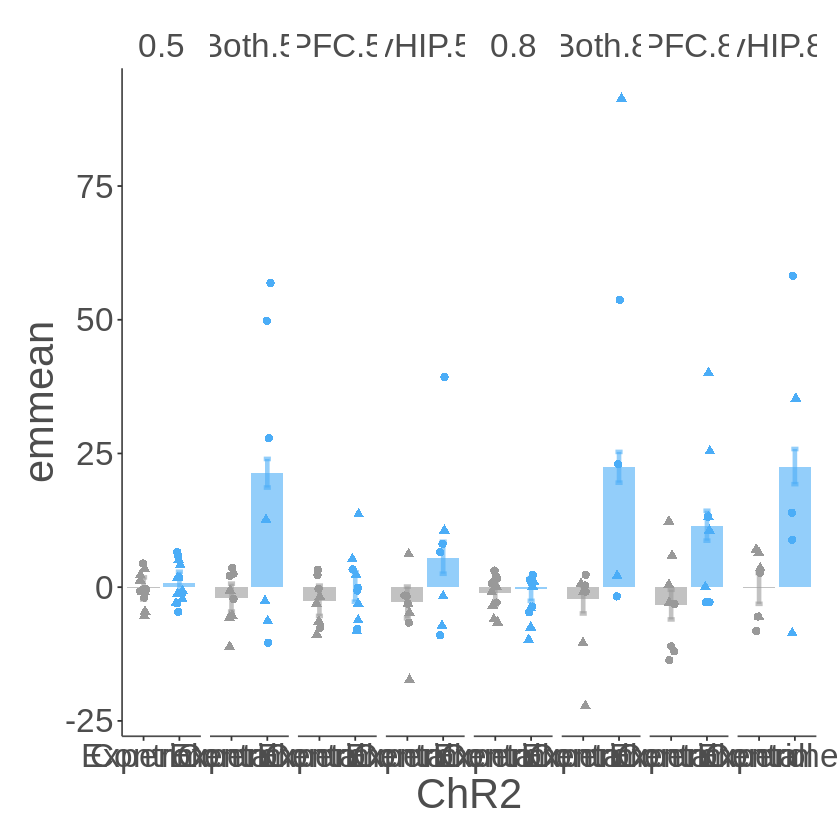

In [5]:
test<- lmer(Change~Previous.Stim*ChR2*Hz_factor + (1|ID)+(1|Day), data=subset(df,(PP.Stim=='0')))

summary(test)

test_means <- emmeans(test, ~ Previous.Stim*Hz_factor|ChR2, type='response')
simp <- pairs(test_means, simple = "each")
test(simp, by = NULL)
test_means

Bulk <- subset(df,(PP.Stim=='0')) %>% group_by(ID,Previous.Stim,ChR2,Hz_factor,sex) %>% summarise(Change=mean(Change))

dtf<- data.frame(test_means)
ggplot(data.frame(dtf)) +
  geom_bar( aes(x = ChR2, y = emmean, fill=ChR2, group=ChR2), stat="identity", size = 5, alpha=.6) +
  geom_errorbar( aes(x=ChR2, ymin=emmean-SE, ymax=emmean+SE,color=ChR2, group=ChR2), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=na.omit(Bulk), aes(x = ChR2, y = Change, color = ChR2, shape=sex), size = 2, width = 0.1) +
  facet_grid(~interaction(Previous.Stim,Hz_factor))+
  plot_theme